# Cross-Frequency Training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers import Activation, concatenate, Input, Dropout, Flatten, BatchNormalization, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn
import h5py, glob
import numpy as np
import itertools
from cnn_utils import *
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(1)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [3]:
### CAE hyp
batch_size = 32
epochs = 200
inChannel = 3
x, y = 88, 120
input_img = Input(shape = (x, y, inChannel))
num_class = 11

## Load Data 

In [5]:
datapath = 'datasets/88x120/*.hdf5'
all_data = glob.glob(datapath)

data_10 = h5py.File(all_data[0], "r")
data_24 = h5py.File(all_data[1], "r")
data_77 = h5py.File(all_data[2], "r")
data_tobb = h5py.File(all_data[3], "r")

# test_path4 = 'Tobb_dataset/tobb_dataset_128x128.hdf5' # file path for TOBB data  
# testset4   = h5py.File(test_path4, "r")

X_train_10 = np.array(data_10["train_img"])
Y_train_10 = np.array(data_10["train_labels"])
# X_valid_orig = np.array(validset["valid_img"])
# Y_valid_orig = np.array(validset["valid_labels"])
X_test_10 = np.array(data_10["test_img"])
Y_test_10 = np.array(data_10["test_labels"])
print('1. Dataset''s Number of training samples: ', len(Y_train_10))
# print('1. Radar''s Number of validation samples: ', len(X_valid_orig))
print('1. Dataset''s Number of test samples: ', len(Y_test_10))

X_train_24 = np.array(data_24["train_img"])
Y_train_24 = np.array(data_24["train_labels"])
# X_valid_orig2 = np.array(validset2["valid_img"])
# Y_valid_orig2 = np.array(validset2["valid_labels"])
X_test_24 = np.array(data_24["test_img"])
Y_test_24 = np.array(data_24["test_labels"])
print('2. Dataset''s Number of training samples: ', len(X_train_24))
# print('2. Radar''s Number of validation samples: ', len(X_valid_orig2))
print('2. Dataset''s Number of test samples: ', len(X_test_24))

X_train_77 = np.array(data_77["train_img"])
Y_train_77 = np.array(data_77["train_labels"])
# X_valid_orig3 = np.array(validset3["valid_img"])
# Y_valid_orig3 = np.array(validset3["valid_labels"])
X_test_77 = np.array(data_77["test_img"])
Y_test_77 = np.array(data_77["test_labels"])
print('3. Dataset''s Number of training samples: ', len(X_train_77))
# print('3. Radar''s Number of validation samples: ', len(X_valid_orig3))
print('3. Dataset''s Number of test samples: ', len(X_test_77))


X_train_tobb = np.array(data_tobb["train_img"])
Y_train_tobb = np.array(data_tobb["train_labels"])
# X_valid_orig3 = np.array(validset3["valid_img"])
# Y_valid_orig3 = np.array(validset3["valid_labels"])
X_test_tobb = np.array(data_tobb["test_img"])
Y_test_tobb = np.array(data_tobb["test_labels"])
print('4. Dataset''s Number of training samples: ', len(X_train_tobb))
# print('4. Radar''s Number of validation samples: ', len(X_valid_orig4))
print('4. Dataset''s Number of test samples: ', len(X_test_tobb))



data_10.close()
data_24.close()
data_77.close()
data_tobb.close()

1. Datasets Number of training samples:  588
1. Datasets Number of test samples:  147
2. Datasets Number of training samples:  1695
2. Datasets Number of test samples:  424
3. Datasets Number of training samples:  519
3. Datasets Number of test samples:  130
4. Datasets Number of training samples:  645
4. Datasets Number of test samples:  162


y = 8


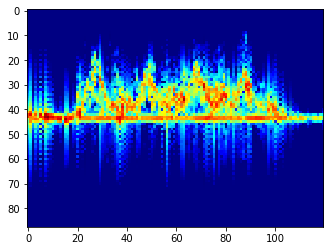

In [6]:
# Example of a spectrogram
index = 7
plt.imshow(X_train_77[index])
print ("y = " + str(np.squeeze(Y_train_77[index])))

## Examine the shapes of data

In [7]:
x_train_10 = X_train_10/255.
# X_valid = X_valid_orig/255.
x_test_10 = X_test_10/255.
y_train_10 = convert_to_one_hot(Y_train_10, num_class).T
# Y_valid = convert_to_one_hot(Y_valid_orig, num_class).T
y_test_10 = convert_to_one_hot(Y_test_10, num_class).T
print ("X_train_10 shape: " + str(x_train_10.shape))
print ("Y_train_10 shape: " + str(y_train_10.shape))
# print ("X_valid shape: " + str(X_valid.shape))
# print ("Y_valid shape: " + str(Y_valid.shape))
print ("X_test_10 shape: " + str(x_test_10.shape))
print ("Y_test_10 shape: " + str(y_test_10.shape)+"\n\n")

x_train_24 = X_train_24/255.
# X_valid = X_valid_orig/255.
x_test_24 = X_test_24/255.
y_train_24 = convert_to_one_hot(Y_train_24, num_class).T
# Y_valid = convert_to_one_hot(Y_valid_orig, num_class).T
y_test_24 = convert_to_one_hot(Y_test_24, num_class).T
print ("X_train_24 shape: " + str(x_train_24.shape))
print ("Y_train_24 shape: " + str(y_train_24.shape))
# print ("X_valid shape: " + str(X_valid.shape))
# print ("Y_valid shape: " + str(Y_valid.shape))
print ("X_test_24 shape: " + str(x_test_24.shape))
print ("Y_test_24 shape: " + str(y_test_24.shape)+"\n\n")

x_train_77 = X_train_77/255.
# X_valid = X_valid_orig/255.
x_test_77 = X_test_77/255.
y_train_77 = convert_to_one_hot(Y_train_77, num_class).T
# Y_valid = convert_to_one_hot(Y_valid_orig, num_class).T
y_test_77 = convert_to_one_hot(Y_test_77, num_class).T
print ("X_train_77 shape: " + str(x_train_77.shape))
print ("Y_train_77 shape: " + str(y_train_77.shape))
# print ("X_valid shape: " + str(X_valid.shape))
# print ("Y_valid shape: " + str(Y_valid.shape))
print ("X_test_77 shape: " + str(x_test_77.shape))
print ("Y_test_77 shape: " + str(y_test_77.shape)+"\n\n")


x_train_tobb = X_train_tobb/255.
# X_valid = X_valid_orig/255.
x_test_tobb = X_test_tobb/255.
y_train_tobb = convert_to_one_hot(Y_train_tobb, num_class).T
# Y_valid = convert_to_one_hot(Y_valid_orig, num_class).T
y_test_tobb = convert_to_one_hot(Y_test_tobb, num_class).T
print ("X_train_tobb shape: " + str(x_train_tobb.shape))
print ("Y_train_tobb shape: " + str(y_train_tobb.shape))
# print ("X_valid shape: " + str(X_valid.shape))
# print ("Y_valid shape: " + str(Y_valid.shape))
print ("X_test_tobb shape: " + str(x_test_tobb.shape))
print ("Y_test_tobb shape: " + str(y_test_tobb.shape)+"\n\n")

X_train_10 shape: (588, 88, 120, 3)
Y_train_10 shape: (588, 11)
X_test_10 shape: (147, 88, 120, 3)
Y_test_10 shape: (147, 11)


X_train_24 shape: (1695, 88, 120, 3)
Y_train_24 shape: (1695, 11)
X_test_24 shape: (424, 88, 120, 3)
Y_test_24 shape: (424, 11)


X_train_77 shape: (519, 88, 120, 3)
Y_train_77 shape: (519, 11)
X_test_77 shape: (130, 88, 120, 3)
Y_test_77 shape: (130, 11)


X_train_tobb shape: (645, 88, 120, 3)
Y_train_tobb shape: (645, 11)
X_test_tobb shape: (162, 88, 120, 3)
Y_test_tobb shape: (162, 11)




# Select Dataset

In [8]:
# set flag: '1' for 77ghz, '2' for 24ghz, '3' for 10ghz
def train_data(flag):
    if flag==0:
        X_train = x_train_10
        Y_train = y_train_10
    elif flag==1:
        X_train = x_train_24
        Y_train = y_train_24
    elif flag==2:
        X_train = x_train_77
        Y_train = y_train_77
    elif flag==3: 
        X_train = x_train_tobb
        Y_train = y_train_tobb
    return X_train, Y_train
def test_data(flag):
    if flag==0:
        X_test = x_test_10
        Y_test = y_test_10
    elif flag==1:
        X_test = x_test_24
        Y_test = y_test_24
    elif flag==2:
        X_test = x_test_77
        Y_test = y_test_77
    elif flag==3: 
        X_test = x_test_tobb
        Y_test = y_test_tobb
    return X_test, Y_test
    

## Define function to plot model accuracy

In [9]:
def plot_fig(i, history):
    fig = plt.figure()
    plt.plot(range(1,EPOCHS+1),history.history['accuracy'],label='Training')
    plt.plot(range(1,EPOCHS+1),history.history['val_accuracy'],label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,EPOCHS])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
    fig.savefig('results/Model'+str(i)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'-acc.png')
    plt.close(fig)
    # summarize history for loss
    fig2 = plt.figure()
    plt.plot(range(1,EPOCHS+1),history.history['loss'],label='Training')
    plt.plot(range(1,EPOCHS+1),history.history['val_loss'],label='Validation')
    plt.legend(loc=0)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([1,EPOCHS])
    plt.grid(True)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    fig2.savefig('results/Model'+str(i)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'-loss.png')
    plt.close(fig2)

# Model

In [9]:
def encoder77(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv01 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
    conv02 = Conv2D(8, (9, 9), activation='relu', padding='same')(input_img)
    out01  = concatenate([conv01,conv02],axis=-1)
    pool01 = MaxPooling2D(pool_size=(2, 2))(out01) #14 x 14 x 32, 64x64x8
    
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool01) # 128x128x8
    conv2 = Conv2D(16, (7, 7), activation='relu', padding='same')(pool01)
    out1  = concatenate([conv1,conv2],axis=-1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(out1) #14 x 14 x 32, 64x64x8
    
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
    conv4 = Conv2D(32, (5, 5), activation='relu', padding='same')(pool1)
    out2  = concatenate([conv3,conv4],axis=-1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(out2) # 16x16x16

    return pool2

In [10]:
def cnn_model(learn_rate=0.001,dense_size=150,drop=0.5,num_class=11):
    """
    model = Sequential()

    model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(11))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.00005),
                metrics=['accuracy'])
    """
    model = Sequential()
#     first = Sequential()
#     second = Sequential()
    model.add(Model(input_img, encoder77(input_img)))
#     model.add(Conv2D(8, (3, 3), border_mode='same', activation='relu'))
#     model.add(Conv2D(8, (9, 9), border_mode='same', activation='relu'))
#     model.add(concatenate(axis=-1))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(16, 3, 3, border_mode='same', activation='relu'))
#     model.add(Conv2D(16, 7, 7, border_mode='same', activation='relu'))
#     model.add(concatenate(axis=-1))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
#     model.add(Conv2D(32, 5, 5, border_mode='same', activation='relu'))
#     model.add(concatenate(axis=-1))
#     model.add(MaxPooling2D(pool_size=(2, 2))) #4,4
    
    model.add(Flatten())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(drop))

    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(drop))
    
    optim = Adam(lr=learn_rate, decay=1e-06) # decay rate = 5e-06 for xethru
    
    model.add(Dense(num_class))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) # categorical_crossentropy
    
    return(model)


In [ ]:
def call_model(modelX):
    model = Sequential()
    model.add(Model(input_img, modelX(*input_img)))
    model.add(Flatten())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(dense_size, activation='relu'))
    
    optim = Adam(lr=learn_rate, decay=1e-06) # decay rate = 5e-06 for xethru
    
    model.add(Dense(11))  # 11 class
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) # categorical_crossentropy
    
    return(model)

In [11]:
# define CNN model
drop = 0.5
lr = 0.001

model = cnn_model()

# define optimiz75


train_flag = 2 # set flag: '0' for 10ghz, '1' for 24ghz, '2' for 77ghz, '3' for tobb
test_flag = 2 # set flag: '0' for 10ghz, '1' for 24ghz, '2' for 77ghz, '3' for tobb

[X_train, Y_train] = train_data(train_flag) 
[X_test, Y_test] = test_data(test_flag)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 64)          51936     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               614550    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)               

# Grid Search

In [24]:
# fit the model
# Params: epochs= 200, batch_size= 32, dense_size= 256, learn_rate= 0.001, Accuracy=0.8781725764274597
epochs = [100,150,200]
batch_size = [8, 16, 32, 64]
dense_size = [100, 150, 256]
learn_rate = [0.001, 0.0005, 0.0001, 0.0002]
acc_hist = []
for i in range(len(epochs)):
    for j in range(len(batch_size)):
        for k in range(len(dense_size)):
            for m in range(len(learn_rate)):
                model = cnn_model(dense_size=dense_size[k],learn_rate=learn_rate[m])
                history = model.fit(X_train, Y_train,
                                batch_size=batch_size[j],
                                epochs=epochs[i],
                                verbose=0,
                                validation_data=(X_test, Y_test)
                                #callbacks = [PlotLossesCallback()]
                                     )
                acc = history.history['val_accuracy'][-1]
                acc_hist.append(acc)
                print('Params: '+'epochs= '+str(epochs[i])+', batch_size= '+str(batch_size[j])+', dense_size= '+
                     str(dense_size[k])+', learn_rate= '+str(learn_rate[m])+', Accuracy='+str(acc))

Params: epochs= 100, batch_size= 8, dense_size= 100, learn_rate= 0.001, Accuracy=0.8020304441452026
Params: epochs= 100, batch_size= 8, dense_size= 100, learn_rate= 0.0005, Accuracy=0.7817258834838867
Params: epochs= 100, batch_size= 8, dense_size= 100, learn_rate= 0.0001, Accuracy=0.807106614112854
Params: epochs= 100, batch_size= 8, dense_size= 100, learn_rate= 0.0002, Accuracy=0.8426395654678345
Params: epochs= 100, batch_size= 8, dense_size= 150, learn_rate= 0.001, Accuracy=0.8527919054031372
Params: epochs= 100, batch_size= 8, dense_size= 150, learn_rate= 0.0005, Accuracy=0.8426395654678345
Params: epochs= 100, batch_size= 8, dense_size= 150, learn_rate= 0.0001, Accuracy=0.8223350048065186
Params: epochs= 100, batch_size= 8, dense_size= 150, learn_rate= 0.0002, Accuracy=0.8020304441452026
Params: epochs= 100, batch_size= 8, dense_size= 256, learn_rate= 0.001, Accuracy=0.8020304441452026
Params: epochs= 100, batch_size= 8, dense_size= 256, learn_rate= 0.0005, Accuracy=0.81725889444

Params: epochs= 150, batch_size= 32, dense_size= 256, learn_rate= 0.0005, Accuracy=0.796954333782196
Params: epochs= 150, batch_size= 32, dense_size= 256, learn_rate= 0.0001, Accuracy=0.817258894443512
Params: epochs= 150, batch_size= 32, dense_size= 256, learn_rate= 0.0002, Accuracy=0.817258894443512
Params: epochs= 150, batch_size= 64, dense_size= 100, learn_rate= 0.001, Accuracy=0.8324872851371765
Params: epochs= 150, batch_size= 64, dense_size= 100, learn_rate= 0.0005, Accuracy=0.817258894443512
Params: epochs= 150, batch_size= 64, dense_size= 100, learn_rate= 0.0001, Accuracy=0.7309644818305969
Params: epochs= 150, batch_size= 64, dense_size= 100, learn_rate= 0.0002, Accuracy=0.7715736031532288
Params: epochs= 150, batch_size= 64, dense_size= 150, learn_rate= 0.001, Accuracy=0.8223350048065186
Params: epochs= 150, batch_size= 64, dense_size= 150, learn_rate= 0.0005, Accuracy=0.807106614112854
Params: epochs= 150, batch_size= 64, dense_size= 150, learn_rate= 0.0001, Accuracy=0.7715

In [25]:
print(np.amax(acc_hist))

0.8781725764274597


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
epochs = [100,150,200]
batch_size = [8, 16, 32, 64]
dense_size = [100, 150, 256]
learn_rate = [0.001, 0.0005, 0.0001, 0.0002]
param_grid = dict(epochs=epochs,batch_size=batch_size,learn_rate=learn_rate, dense_size=dense_size)
Y_train_int = np.argmax(Y_train, axis=1)
print(Y_train_int[0:10])
model = KerasClassifier(build_fn=cnn_model, verbose=0)
grid = GridSearchCV(estimator=model, scoring='accuracy', param_grid=param_grid, n_jobs=1, cv=3) # use all the cores (n_ jobs =-1), or set to 1 if err
grid_result = grid.fit(X_train, Y_train_int)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

[ 0  6 10  8  7  0 10  5  5  3]


### Testing Accuracy

In [160]:
model1.evaluate(X_test,Y_test)

154/154 [==============================] - 0s 3ms/step


[0.5321738294192723, 0.8246753215789795]

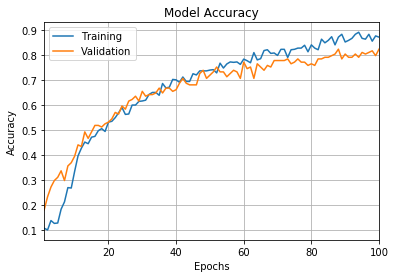

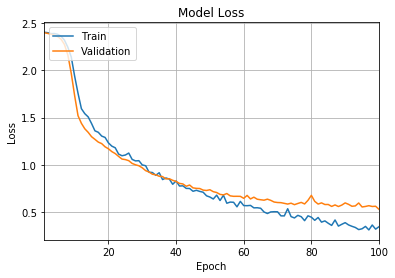

In [161]:
# plot model accuracy
model_num = 3
plot_fig(model_num, history1)

##### Save Trained Model

In [162]:

MODEL_FILE = "models/11_class_"+str(radar)+".h5" # save path
model1.save_weights(MODEL_FILE)

### Confusion Matrix

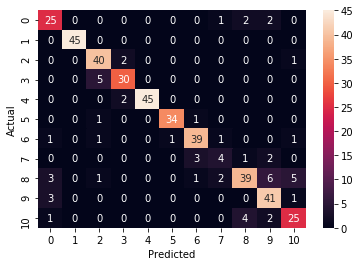

In [13]:
import pandas as pd
import seaborn as sn

predictions = model1.predict(X_test)
Y_pred = np.argmax(predictions, axis=1)
Y_test_int = np.argmax(Y_test, axis=1)
#print(predictions[0:5])
#print(Y_pred[0:5])
#print(Y_test_int[0:5])
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
fig3 = plt.figure()
sn.heatmap(confusion_matrix, annot=True)
# fig3.savefig('results/Conf_Model'+str(model_num)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'.png')
# plt.close(fig3)

In [222]:
datagen = ImageDataGenerator(rescale=1.0/255.0,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=0, # 20
#     width_shift_range=0, # 0.2
#     height_shift_range=0, # 0.2
    #horizontal_flip=True
    )

In [223]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

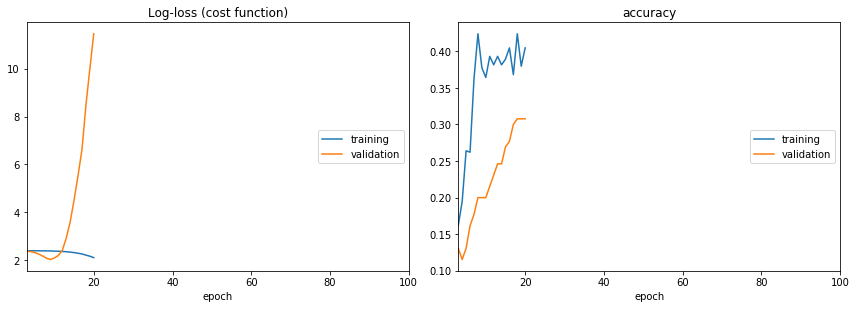

Log-loss (cost function):
training   (min:    2.109, max:    2.398, cur:    2.109)
validation (min:    2.031, max:   11.458, cur:   11.458)

accuracy:
training   (min:    0.069, max:    0.424, cur:    0.405)
validation (min:    0.077, max:    0.308, cur:    0.308)
Epoch 21/100
2/8 [======>.......................] - ETA: 1s - loss: 2.0664 - accuracy: 0.4062

KeyboardInterrupt: 

In [224]:
# fits the model on batches with real-time data augmentation:
model2 = cnn_model(drop)
model2.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
history2 = model2.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch= X_train.shape[0] / BATCH_SIZE, epochs=EPOCHS,
                    validation_data = (X_test, Y_test), 
                    validation_steps= X_test.shape[0] / BATCH_SIZE,
                   callbacks = [PlotLossesCallback()])